### [SETUP] Import Libraries

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'dimgrey', 'grid.color':'lightgrey'})

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch_scatter
from torch_geometric.data import Data
from dgl import DGLGraph
import dgl.function as fn
from functools import partial

# # The PyG built-in GCNConv
# from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import scipy.sparse as scsp
from sklearn.cluster import KMeans
import copy
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv
from torch_geometric import utils
import os
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import networkx as nx

### Transactions Dataset Overview

In [35]:
def load_pickle(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

G = load_pickle('./Ethereum Phishing Transaction Network/MulDiGraph.pkl')

In [36]:
pagerank_values = nx.pagerank(G)

In [51]:
betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness Done")

closeness_centrality = nx.closeness_centrality(G)
print("Closeness Done")

eigenvector_centrality = nx.eigenvector_centrality(G)
print("Eigenvector Done")

katz_centrality = nx.katz_centrality_numpy(G)
print("Katz Done")

eccentricity = nx.eccentricity(G)
print("Eccentricity Done")

KeyboardInterrupt: 

In [5]:
# Initialize data for nodes and edges
nodes_data = []
edges_data = []
num = 0

for node in G.nodes(data=True):

    print(num)
    num += 1

    accId = node[0]
    isp = node[1]['isp']

    in_edges = G.in_edges(accId, data=True)
    in_amounts = [edge[2]['amount'] for edge in in_edges]
    in_sources = set([edge[0] for edge in in_edges])

    out_edges = G.out_edges(accId, data=True)
    out_amounts = [edge[2]['amount'] for edge in out_edges]
    out_dests = set([edge[1] for edge in out_edges])

    nodes_data.append({
        'accId': int(accId, 16),
        'class': isp,

        'in_ETH_min': min(in_amounts, default=None) if len(in_amounts) > 0 else 0,
        'in_ETH_max': max(in_amounts, default=None) if len(in_amounts) > 0 else 0,
        'in_ETH_mean': pd.Series(in_amounts).mean() if len(in_amounts) > 0 else 0,
        'in_ETH_median': pd.Series(in_amounts).median() if len(in_amounts) > 0 else 0,
        'in_ETH_total': sum(in_amounts) if len(in_amounts) > 0 else 0,
        'in_ETH_num': len(in_edges),
        'in_addr_num': len(in_sources),

        'out_ETH_min': min(out_amounts, default=None) if len(out_amounts) > 0 else 0,
        'out_ETH_max': max(out_amounts, default=None) if len(out_amounts) > 0 else 0,
        'out_ETH_mean': pd.Series(out_amounts).mean() if len(out_amounts) > 0 else 0,
        'out_ETH_median': pd.Series(out_amounts).median() if len(out_amounts) > 0 else 0,
        'out_ETH_total': sum(out_amounts) if len(out_amounts) > 0 else 0,
        'out_ETH_num': len(out_edges),
        'out_addr_num': len(out_dests),
        'pagerank': pagerank_values[accId],

        'degree': G.degree(accId),
        # 'betweenness_centrality': betweenness_centrality[accId],
        # 'closeness_centrality': closeness_centrality[accId],
        # 'eigenvector_centrality': eigenvector_centrality[accId],
        # 'avg_neighbor_degree': nx.average_neighbor_degree(G, nodes=[accId]),
        # 'katz_centrality': katz_centrality[accId],
        # 'eccentricity': eccentricity[accId],
    })

for edge in G.edges(data=True):

    accId1 = edge[0]
    accId2 = edge[1]

    edges_data.append({
        'accId1': int(accId1, 16),
        'accId2': int(accId2, 16),
    })

# Create dataframes
nodes_df = pd.DataFrame(nodes_data)
edges_df = pd.DataFrame(edges_data)

# Save dataframes to CSV or use as needed
nodes_df.to_csv('./Ethereum Phishing Transaction Network/ethereum_txs_nodes.csv', index=False)
edges_df.to_csv('./Ethereum Phishing Transaction Network/ethereum_txs_edgelist.csv', index=False)


In [6]:
print("\nAccount nodes (features & classes): \n")
df_txs_nodes = nodes_df
display(df_txs_nodes)

print("\nTransaction edgelist: \n")
df_txs_edgelist = edges_df

display(df_txs_edgelist)


Account nodes (features & classes): 



,accId,class,in_ETH_min,in_ETH_max,in_ETH_mean,in_ETH_median,in_ETH_total,in_ETH_num,in_addr_num,out_ETH_min,out_ETH_max,out_ETH_mean,out_ETH_median,out_ETH_total,out_ETH_num,out_addr_num,pagerank,degree
0,177658215036513426671520303810532342678921841185,0,1.995000,500.000000,62.912247,40.000000,13526.133102,215,18,0.000200,499.999160,8.328017,1.133987,13524.699933,1624,1327,6.168217e-07,1839
1,105058176988455180849784360140635030023033677921,0,2.344623,2.344623,2.344623,2.344623,2.344623,1,1,2.344203,2.344203,2.344203,2.344203,2.344203,1,1,1.333369e-07,2
2,1073177581925407956309658639626493290162102849515,1,0.500000,10.000000,3.533512,2.287102,28.268098,8,7,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,8.449769e-07,8
3,213724907882750922102310790726732369422632856227,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.489485,0.489485,0.489485,0.489485,0.489485,1,1,1.331609e-07,1
4,1033618310653199987383472215097185760827692870773,0,0.005000,1.467535,0.220777,0.163320,13.908974,63,16,0.000000,1.012500,0.084270,0.052500,13.988820,166,116,8.827056e-07,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973484,976487771261796333943158662928275652889421629351,0,0.738265,0.738265,0.738265,0.738265,0.738265,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1.415685e-07,1
2973485,1140526842204188367179608603619981153757494766024,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1.337601e-07,1
2973486,481750734136704374347616541858618439955584306923,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.010960,0.010960,0.010960,0.010960,0.010960,1,1,1.331609e-07,1
2973487,667042349852779106023332481667829776833785926298,0,0.030000,0.040000,0.035000,0.035000,0.070000,2,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1.343594e-07,2



Transaction edgelist: 



,accId1,accId2
0,177658215036513426671520303810532342678921841185,105058176988455180849784360140635030023033677921
1,177658215036513426671520303810532342678921841185,733179778909834987999391570154975618428068799454
2,177658215036513426671520303810532342678921841185,733179778909834987999391570154975618428068799454
3,177658215036513426671520303810532342678921841185,358337481750454600744589498260383146523763377724
4,177658215036513426671520303810532342678921841185,358337481750454600744589498260383146523763377724
...,...,...
13551298,87091709024981891691822128735066344039197852073,244007241525034687365590337876886639515227140055
13551299,87091709024981891691822128735066344039197852073,244007241525034687365590337876886639515227140055
13551300,481750734136704374347616541858618439955584306923,184038720374047853340642723872322749505196654295
13551301,520395524511023335124303324366459044306297633418,1308031607850507950554886645722394695667708492116


In [16]:
busy_df = df_txs_nodes.nlargest(5000, columns=['in_addr_num', 'out_addr_num'])
big_trans_df = df_txs_nodes.nlargest(5000, columns=['in_ETH_total', 'out_ETH_total'])
pagerank_df = df_txs_nodes.nlargest(5000, columns=['pagerank'])

df_txs_nodes = df_txs_nodes[df_txs_nodes['accId'].isin(busy_df['accId']) | df_txs_nodes['accId'].isin(big_trans_df['accId']) | df_txs_nodes['accId'].isin(pagerank_df['accId']) | df_txs_nodes['class'] == 1]

print("\nFiltered account nodes (features & classes): \n")
display(df_txs_nodes)


df_txs_edgelist = df_txs_edgelist[df_txs_edgelist['accId1'].isin(df_txs_nodes['accId']) & df_txs_edgelist['accId2'].isin(df_txs_nodes['accId'])]

print("\nTransaction edgelist: \n")
display(df_txs_edgelist)



Filtered account nodes (features & classes): 



,accId,class,in_ETH_min,in_ETH_max,in_ETH_mean,in_ETH_median,in_ETH_total,in_ETH_num,in_addr_num,out_ETH_min,out_ETH_max,out_ETH_mean,out_ETH_median,out_ETH_total,out_ETH_num,out_addr_num,pagerank,degree
0,177658215036513426671520303810532342678921841185,0,1.995000e+00,500.00000,62.912247,40.000000,13526.133102,215,18,0.000200,499.999160,8.328017,1.133987,13524.699933,1624,1327,6.168217e-07,1839
2,1073177581925407956309658639626493290162102849515,1,5.000000e-01,10.00000,3.533512,2.287102,28.268098,8,7,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,8.449769e-07,8
6,859284335326272371548723547087225057492496899320,0,5.000000e-03,30.00000,2.145115,0.700000,276.719856,129,97,0.000000,3.500000,0.611196,0.300000,11.001530,18,12,9.372559e-07,147
7,492293783146356869670525059291990467955676821777,0,7.777778e-09,399.98938,314.702285,320.385985,36505.465091,116,3,0.000100,242.928382,3.473151,1.000000,40149.631173,11560,7889,1.389195e-07,11676
8,1363409748428135061150168007656458483406884184145,0,1.000000e+00,399.99938,322.732018,317.032775,35500.522000,110,1,0.000205,219.995000,3.389103,1.000000,39269.537099,11587,7881,1.359559e-07,11697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966158,797934625717439426625530930565773185060414920452,0,9.197605e+00,139.50000,61.876325,51.258600,1051.897526,17,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1.346809e-07,17
2966190,1003001463992169924184414274555014066628414255095,0,1.000000e-02,500.00000,237.720872,282.158518,11172.880978,47,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1.373634e-07,47
2966603,1044923137550906183722974546427882418110417938629,0,1.893688e+02,500.00000,396.456260,500.000000,1189.368781,3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1.334291e-07,3
2966621,1436476076719676654232664842494525431957353863763,0,2.351056e+00,47.27500,17.237760,10.843876,982.552315,57,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1.382575e-07,57



Transaction edgelist: 



,accId1,accId2
1,177658215036513426671520303810532342678921841185,733179778909834987999391570154975618428068799454
2,177658215036513426671520303810532342678921841185,733179778909834987999391570154975618428068799454
6,177658215036513426671520303810532342678921841185,286658208434198897555701939738136566915490134719
7,177658215036513426671520303810532342678921841185,286658208434198897555701939738136566915490134719
8,177658215036513426671520303810532342678921841185,286658208434198897555701939738136566915490134719
...,...,...
13498950,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850
13498951,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850
13498952,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850
13498953,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850


In [17]:
def balance_graph_with_smote_and_edge_generator(df_txs_edgelist, df_txs_nodes, minority_class=1, k_neighbors=5, smote_ratio=1.0, under_sampling_ratio=0.5, edge_generator_weight=1.0):
    # Step 1: Identify minority class nodes
    minority_nodes = df_txs_nodes[df_txs_nodes['class'] == minority_class]

    # Step 2: Find neighbors for each minority class node
    neighbor_dict = {}
    for index, row in df_txs_edgelist.iterrows():
        if row['accId1'] in minority_nodes['accId'].values and row['accId2'] in minority_nodes['accId'].values:
            if row['accId1'] not in neighbor_dict:
                neighbor_dict[row['accId1']] = []
            neighbor_dict[row['accId1']].append(row['accId2'])

            if row['accId2'] not in neighbor_dict:
                neighbor_dict[row['accId2']] = []
            neighbor_dict[row['accId2']].append(row['accId1'])

    # Step 3: Use SMOTE to generate synthetic nodes
    smote = SMOTE(sampling_strategy=smote_ratio, k_neighbors=k_neighbors)
    rus = RandomUnderSampler(sampling_strategy=under_sampling_ratio)
    pipeline = Pipeline([('under', rus), ('over', smote)])

    # Add majority class to minority class for oversampling
    majority_nodes = df_txs_nodes[df_txs_nodes['class'] != minority_class]
    minority_features = minority_nodes.drop(columns=['class'])
    majority_features = majority_nodes.drop(columns=['class'])

    synthetic_features, synthetic_classes = pipeline.fit_resample(pd.concat([minority_features, majority_features]), pd.concat([minority_nodes['class'], majority_nodes['class']]))

    # Add synthetic nodes to the original dataframe
    synthetic_nodes = pd.DataFrame(synthetic_features, columns=minority_features.columns)
    synthetic_nodes['class'] = synthetic_classes  # Assign class values to synthetic nodes
    df_txs_nodes = pd.concat([df_txs_nodes, synthetic_nodes], ignore_index=True)

    # Step 4: Generate synthetic edges using an edge generator
    real_nodes = df_txs_nodes.dropna(subset=['class'])
    real_features = real_nodes.drop(columns=['class'])

    # Assuming h1_v and h1_u are the node representations
    h1_synthetic = synthetic_nodes.drop(columns=['class'])
    h1_real = real_nodes.drop(columns=['class'])

    # Weighted inner product for edge generation
    S = np.random.rand(h1_real.shape[1], h1_synthetic.shape[1])  # Initialize S with random values
    edge_weights = cosine_similarity(h1_real.values @ S.T, h1_synthetic.values)

    # Apply a sigmoid activation function to mimic the edge generator in your description
    edge_weights = 1 / (1 + np.exp(-edge_weights))

    # Adjust the weights according to the specified weight parameter
    edge_weights *= edge_generator_weight

    # Create a dataframe for synthetic edges
    synthetic_edges = pd.DataFrame(columns=['accId1', 'accId2', 'edge_weight'])
    # for i, minority_node in enumerate(minority_nodes['accId']):
    #     if minority_node in neighbor_dict:
    #         neighbors = neighbor_dict[minority_node]
    #         for j, neighbor in enumerate(neighbors):
    #             if neighbor not in synthetic_nodes['accId'].values:
    #                 synthetic_nodes = synthetic_nodes.append({'accId': neighbor}, ignore_index=True)
    #                 synthetic_edges = synthetic_edges.append({'accId1': minority_node, 'accId2': neighbor, 'edge_weight': edge_weights[i, j]}, ignore_index=True)

    # Add synthetic edges to the original dataframe
    df_txs_edgelist = pd.concat([df_txs_edgelist, synthetic_edges], ignore_index=True)

    return df_txs_edgelist, df_txs_nodes

In [18]:
df_txs_edgelist_synthetic = df_txs_edgelist.copy()
df_txs_nodes_synthetic = df_txs_nodes.copy()

df_txs_edgelist_synthetic, df_txs_nodes_synthetic = balance_graph_with_smote_and_edge_generator(df_txs_edgelist_synthetic, df_txs_nodes_synthetic)
display(df_txs_nodes_synthetic)
display(df_txs_edgelist_synthetic)

,accId,class,in_ETH_min,in_ETH_max,in_ETH_mean,in_ETH_median,in_ETH_total,in_ETH_num,in_addr_num,out_ETH_min,out_ETH_max,out_ETH_mean,out_ETH_median,out_ETH_total,out_ETH_num,out_addr_num,pagerank,degree
0,177658215036513426671520303810532342678921841185,0,1.995000e+00,500.000000,62.912247,40.000000,13526.133102,215,18,0.000200,499.999160,8.328017,1.133987,13524.699933,1624,1327,6.168217e-07,1839
1,1073177581925407956309658639626493290162102849515,1,5.000000e-01,10.000000,3.533512,2.287102,28.268098,8,7,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,8.449769e-07,8
2,859284335326272371548723547087225057492496899320,0,5.000000e-03,30.000000,2.145115,0.700000,276.719856,129,97,0.000000,3.500000,0.611196,0.300000,11.001530,18,12,9.372559e-07,147
3,492293783146356869670525059291990467955676821777,0,7.777778e-09,399.989380,314.702285,320.385985,36505.465091,116,3,0.000100,242.928382,3.473151,1.000000,40149.631173,11560,7889,1.389195e-07,11676
4,1363409748428135061150168007656458483406884184145,0,1.000000e+00,399.999380,322.732018,317.032775,35500.522000,110,1,0.000205,219.995000,3.389103,1.000000,39269.537099,11587,7881,1.359559e-07,11697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16679,4812457780373716273202669429415256346783163351...,1,1.597174e-02,0.878973,0.521207,0.522389,3.948410,7,6,0.250732,1.167229,0.597857,0.503377,3.942693,6,2,3.395090e-07,13
16680,8091561795829345553514516907331351200069519933...,1,2.035750e-03,19.854993,1.989396,0.821204,206.730856,97,83,0.000000,145.393878,1.842456,0.000000,291.108097,149,60,7.180436e-06,247
16681,8842823061113399846233803839341472432799298355...,1,3.375315e-01,155.110245,19.119111,14.379754,1338.337789,63,9,0.012728,309.931635,39.226080,14.662768,1333.686726,30,8,1.405020e-07,93
16682,7717987267631460504226707767451008977012722237...,1,4.740897e-01,1.100558,0.813071,0.771720,2.768043,3,3,0.427733,2.525332,0.811848,0.479506,2.762521,3,3,6.065556e-07,7


,accId1,accId2,edge_weight
0,177658215036513426671520303810532342678921841185,733179778909834987999391570154975618428068799454,NaN
1,177658215036513426671520303810532342678921841185,733179778909834987999391570154975618428068799454,NaN
2,177658215036513426671520303810532342678921841185,286658208434198897555701939738136566915490134719,NaN
3,177658215036513426671520303810532342678921841185,286658208434198897555701939738136566915490134719,NaN
4,177658215036513426671520303810532342678921841185,286658208434198897555701939738136566915490134719,NaN
...,...,...,...
1371031,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850,NaN
1371032,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850,NaN
1371033,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850,NaN
1371034,821707108153907313682185205592409181084969105943,724643093837809265350756425028173798839497387850,NaN


In [19]:
len(df_txs_nodes_synthetic[df_txs_nodes_synthetic['class'] == 1])

3495

### Splitting the Data into Training, Validation, and Test sets 

In [20]:
def random_split_transd(new_nodes, new_edges, train_size, test_size):
    """
    Create and return the training, validation, and test set by randomly splitting
    the node indices to these three sets. Keep edge_index known for all sets.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        train_size    The node size proportion in training set
        test_size     The node size proportion in test set

    Returns:
        data          A Data object that stores node features, edge_index, and labels
        dict          A dictionary that stores training, validation, test set node indices
    """
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))
    nodes_id = new_nodes.iloc[:, 0].to_numpy()

    # Create a dictionary that maps nodeId to index in the dataframe.
    id2idx = {}
    for i in range(new_nodes.shape[0]):
        id2idx[new_nodes.iloc[i, 0]] = i

    # Construct edge_index with same node indexing as in features and labels
    edge_idx = np.zeros((2, new_edges.shape[0]), dtype = np.int64)
    for index in range(new_edges.shape[0]):
        node1 = id2idx[new_edges.iloc[index, 0]]
        node2 = id2idx[new_edges.iloc[index, 1]]
        edge_idx[:, index] = [node1, node2]
    edge_index = torch.LongTensor(edge_idx)

    train_index, test_index = train_test_split(np.arange(labels.shape[0]),
                                               test_size = 1 - train_size,
                                               random_state = 42)
    val_index, test_index = train_test_split(test_index,
                                             test_size = test_size / (1 - train_size),
                                             random_state = 42)

    # Construct the training, validation, test set and store
    # in a dictionary, 'data'.
    data = Data(x = features, edge_index = edge_index, y = torch.tensor(labels, dtype=torch.float32))

    return data, {'train': torch.tensor(train_index, dtype=torch.long), 'val': torch.tensor(val_index, dtype=torch.long), 'test': torch.tensor(test_index, dtype=torch.long)}

In [21]:
train_node_size, test_node_size = 0.5930547203848466, 0.29252212009277556

data, split_idx = random_split_transd(df_txs_nodes, df_txs_edgelist, train_size = train_node_size,
                         test_size = test_node_size)

data_smote, split_idx_smote = random_split_transd(df_txs_nodes_synthetic, df_txs_edgelist_synthetic, train_size = train_node_size,
                         test_size = test_node_size)

display(data)
display(data_smote)

/var/folders/br/9fqjdr8562100jwl_tm_xbb00000gn/T/ipykernel_7330/840093698.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = Data(x = features, edge_index = edge_index, y = torch.tensor(labels, dtype=torch.float32))


Data(x=[12024, 16], edge_index=[2, 1371036], y=[12024])

Data(x=[16684, 16], edge_index=[2, 1371036], y=[16684])

### GNN Models

In [22]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()

        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gcn2(h, edge_index)
        return out

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.6)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, concat=False, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gat2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

### Training and Testing Functions

In [23]:
def train_evaluate(model, data, split_idx, criterion, optimizer, rgcn, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()

        if rgcn:
            out = model(data.x, data.edge_index, data.edge_attr)
        else:
            out = model(data.x, data.edge_index)

        loss = criterion(out[split_idx['train']], data.y[split_idx['train']].unsqueeze(1))
        acc = accuracy(out[split_idx['train']], data.y[split_idx['train']].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[split_idx['val']], data.y[split_idx['val']].unsqueeze(1))
        val_acc = accuracy(out[split_idx['val']], data.y[split_idx['val']].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

### NN Configurations

In [26]:
class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 16
    output_dim = 1
    hidden_size = 128
    num_epochs = 100
    checkpoints_dir = './models/ethereum_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using device:", Config.device)

Using device: cpu


### Training GCN

In [27]:
gcn_model = GCN(Config.input_dim, 166, Config.output_dim).to(Config.device)

data_train = data.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gcn_model,
              data_train,
              split_idx,
              criterion,
              optimizer,
              0,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gcn_best_model.pth.tar')

Epoch   0 | Train Loss: 56023.117 | Train Acc:  29.75% | Val Loss: 47926.92 | Val Acc: 33.43%
Saving model for best loss
Epoch  10 | Train Loss: 6007.351 | Train Acc:  81.33% | Val Loss: 7847.83 | Val Acc: 80.74%
Saving model for best loss
Epoch  20 | Train Loss: 2521.943 | Train Acc:  89.48% | Val Loss: 3575.80 | Val Acc: 88.01%
Saving model for best loss
Epoch  30 | Train Loss: 3813.922 | Train Acc:  89.65% | Val Loss: 5713.34 | Val Acc: 88.08%
Epoch  40 | Train Loss: 2872.213 | Train Acc:  89.35% | Val Loss: 3972.07 | Val Acc: 88.08%
Epoch  50 | Train Loss: 2698.886 | Train Acc:  90.11% | Val Loss: 4475.22 | Val Acc: 88.52%
Epoch  60 | Train Loss: 2865.331 | Train Acc:  90.04% | Val Loss: 3701.02 | Val Acc: 88.88%
Epoch  70 | Train Loss: 3050.188 | Train Acc:  89.68% | Val Loss: 4535.29 | Val Acc: 88.52%
Epoch  80 | Train Loss: 1685.217 | Train Acc:  89.93% | Val Loss: 2417.21 | Val Acc: 88.81%
Saving model for best loss
Epoch  90 | Train Loss: 2038.346 | Train Acc:  89.48% | Val Lo

GCN(
  (gcn1): GCNConv(16, 166)
  (gcn2): GCNConv(166, 1)
)

### Testing GCN

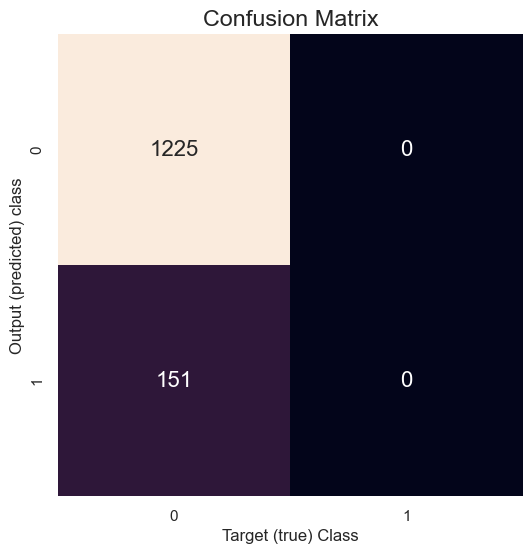

              precision    recall  f1-score   support

       licit       0.89      1.00      0.94      1225
     illicit       0.00      0.00      0.00       151

    accuracy                           0.89      1376
   macro avg       0.45      0.50      0.47      1376
weighted avg       0.79      0.89      0.84      1376

Test data fraud cases, percentage: 0.0 %


/Users/feranmi/.venvs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/feranmi/.venvs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/feranmi/.venvs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gcn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gcn_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[split_idx['val']].detach().cpu().numpy(), y_test_preds[split_idx['val']])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[split_idx['val']].detach().cpu().numpy(),
                            y_test_preds[split_idx['val']],
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[split_idx['test']].detach().cpu().numpy().sum() / len(data_train.y[split_idx['test']]) *100} %")

### Training GAT

In [29]:
gat_model = GAT(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)

data_train = data.to(Config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gat_model,
              data_train,
              split_idx,
              criterion,
              optimizer,
              0,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 24671.939 | Train Acc:  87.24% | Val Loss: 22359.64 | Val Acc: 86.85%
Saving model for best loss
Epoch  10 | Train Loss: 25686.545 | Train Acc:  84.22% | Val Loss: 21949.94 | Val Acc: 83.72%
Saving model for best loss
Epoch  20 | Train Loss: 22481.148 | Train Acc:  84.15% | Val Loss: 16262.69 | Val Acc: 82.92%
Saving model for best loss
Epoch  30 | Train Loss: 21721.549 | Train Acc:  84.07% | Val Loss: 23495.37 | Val Acc: 83.36%
Epoch  40 | Train Loss: 13058.439 | Train Acc:  84.61% | Val Loss: 16443.64 | Val Acc: 83.43%
Epoch  50 | Train Loss: 4848.560 | Train Acc:  81.84% | Val Loss: 3342.55 | Val Acc: 80.60%
Saving model for best loss
Epoch  60 | Train Loss: 9228.601 | Train Acc:  83.11% | Val Loss: 9582.92 | Val Acc: 82.56%
Epoch  70 | Train Loss: 5004.889 | Train Acc:  86.00% | Val Loss: 5315.95 | Val Acc: 85.32%
Epoch  80 | Train Loss: 16279.391 | Train Acc:  86.55% | Val Loss: 16334.83 | Val Acc: 85.90%
Epoch  90 | Train Loss: 15765.426 | Train Acc:  85.6

GAT(
  (gat1): GATv2Conv(16, 128, heads=8)
  (gat2): GATv2Conv(1024, 1, heads=1)
)

### Testing GAT

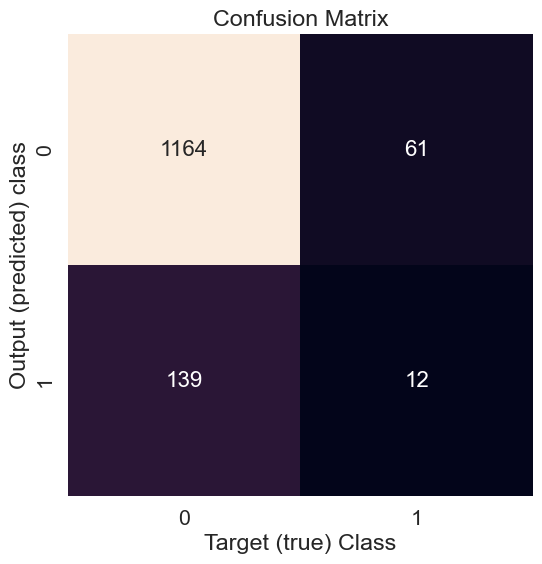

              precision    recall  f1-score   support

       licit       0.89      0.95      0.92      1225
     illicit       0.16      0.08      0.11       151

    accuracy                           0.85      1376
   macro avg       0.53      0.51      0.51      1376
weighted avg       0.81      0.85      0.83      1376

Test data fraud cases, percentage: 5.457646389994315 %


In [30]:
gat_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gat_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gat_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[split_idx['val']].detach().cpu().numpy(), y_test_preds[split_idx['val']])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[split_idx['val']].detach().cpu().numpy(),
                            y_test_preds[split_idx['val']],
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[split_idx['test']].detach().cpu().numpy().sum() / len(data_train.y[split_idx['test']]) *100} %")

### Training SmGCN

In [52]:
gcn_model = GCN(Config.input_dim, 166, Config.output_dim).to(Config.device)

data_train = data_smote.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gcn_model,
              data_train,
              split_idx_smote,
              criterion,
              optimizer,
              0,
              Config.num_epochs,
              Config.checkpoints_dir,
              'smgcn_best_model.pth.tar')

Epoch   0 | Train Loss: 22504.018 | Train Acc:  43.39% | Val Loss: 23895.08 | Val Acc: 43.01%
Saving model for best loss
Epoch  10 | Train Loss: 8217.765 | Train Acc:  70.00% | Val Loss: 6876.42 | Val Acc: 71.71%
Saving model for best loss
Epoch  20 | Train Loss: 1901.113 | Train Acc:  76.96% | Val Loss: 1998.15 | Val Acc: 77.79%
Saving model for best loss
Epoch  30 | Train Loss: 2318.784 | Train Acc:  78.62% | Val Loss: 2638.61 | Val Acc: 79.78%
Epoch  40 | Train Loss: 2553.775 | Train Acc:  78.54% | Val Loss: 3007.43 | Val Acc: 79.62%
Epoch  50 | Train Loss: 2373.990 | Train Acc:  78.87% | Val Loss: 2831.46 | Val Acc: 79.99%
Epoch  60 | Train Loss: 1710.078 | Train Acc:  78.90% | Val Loss: 1339.93 | Val Acc: 80.36%
Saving model for best loss
Epoch  70 | Train Loss: 2050.537 | Train Acc:  80.00% | Val Loss: 2272.66 | Val Acc: 81.09%
Epoch  80 | Train Loss: 1795.161 | Train Acc:  79.81% | Val Loss: 2081.36 | Val Acc: 79.94%
Epoch  90 | Train Loss: 1710.235 | Train Acc:  80.47% | Val Lo

GCN(
  (gcn1): GCNConv(16, 166)
  (gcn2): GCNConv(166, 1)
)

### Testing SmGCN (test is run on graph before augmentation)

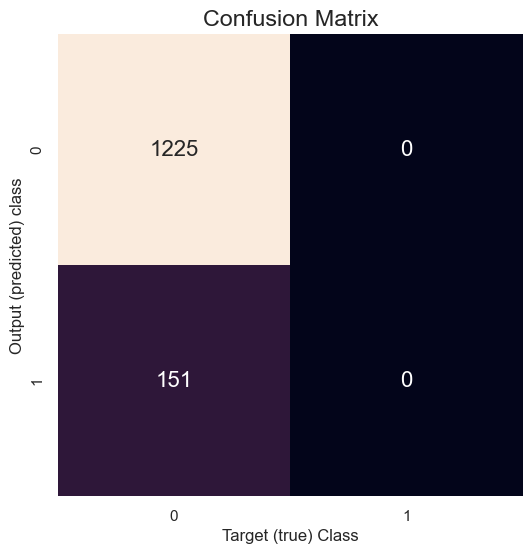

              precision    recall  f1-score   support

       licit       0.89      1.00      0.94      1225
     illicit       0.00      0.00      0.00       151

    accuracy                           0.89      1376
   macro avg       0.45      0.50      0.47      1376
weighted avg       0.79      0.89      0.84      1376

Test data fraud cases, percentage: 0.0 %


/Users/feranmi/.venvs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/feranmi/.venvs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/feranmi/.venvs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'smgcn_best_model.pth.tar'))['state_dict'])
data_train = data.to(Config.device)
y_test_preds = test(gcn_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[split_idx['val']].detach().cpu().numpy(), y_test_preds[split_idx['val']])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[split_idx['val']].detach().cpu().numpy(),
                            y_test_preds[split_idx['val']],
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[split_idx['test']].detach().cpu().numpy().sum() / len(data_train.y[split_idx['test']]) *100} %")